In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers

In [2]:
# loading csv files

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# pulling out text and target data

y = train['target'].values
tweet_train = train['text'].values
tweet_test = test['text'].values

In [4]:
# preprocessing text for model

tk = Tokenizer()
tk.fit_on_texts(list(tweet_train))
tokenized_train = tk.texts_to_sequences(tweet_train)
tokenized_test = tk.texts_to_sequences(tweet_test)
vocab_size = len(tk.word_index) + 1
# vocab size is 19424

In [5]:
# padding preprocessed text because not every tweet has same length

max_len = 150
X_train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [6]:
embed_size = 512
epoch_size = 50

In [7]:
model = tf.keras.Sequential([
    layers.Embedding(vocab_size, embed_size, input_shape=(max_len, )),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(momentum=0.9, nesterov=True, lr=0.005, decay=1e-6),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 512)          11622912  
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 11,886,081
Trainable params: 11,886,081
Non-trainable params: 0
____________________________________________

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [10]:
history = model.fit(X_train, y, epochs=epoch_size,
                    validation_split=0.2, callbacks=[callback], shuffle=True)

Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.6808 - accuracy: 0.5793 - val_loss: 0.6892 - val_accuracy: 0.5345
Epoch 2/50
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6706 - accuracy: 0.5793 - val_loss: 0.6722 - val_accuracy: 0.5345
Epoch 3/50
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6538 - accuracy: 0.6107 - val_loss: 0.6431 - val_accuracy: 0.6815
Epoch 4/50
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6364 - accuracy: 0.6496 - val_loss: 0.6266 - val_accuracy: 0.6743
Epoch 5/50
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6237 - accuracy: 0.6591 - val_loss: 0.6217 - val_accuracy: 0.6861
Epoch 6/50
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6099 - accuracy: 0.6834 - val_loss: 0.6134 - val_accuracy: 0.6881
Epoch 7/50
6090/6090 [==============================] - 9s 2ms/sample - los

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

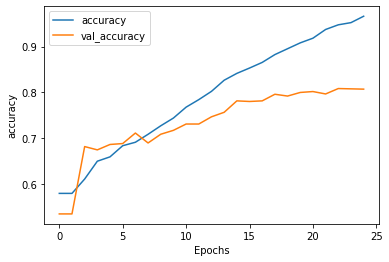

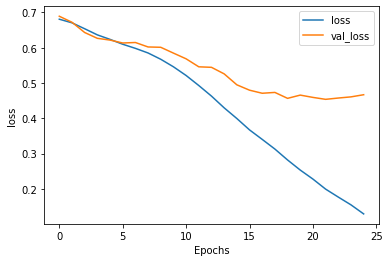

In [12]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [15]:
test['target'] = model.predict(X_test)

# since this is binary classification, target values >0.5 indicate disaster, <0.5 indicate non-disaster

In [16]:
test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0.633856
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.904526
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.893093
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.445602
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.880710


In [17]:
# we can see that for the most part, model can predict disasters
# however, this model still experiences overfitting (observe loss graph as epochs increase)# save this dataframe to csv to view all predictions

test.to_csv('test_pred.csv')